In [2]:
# Data Cleaning and Validation
# 
# This notebook is designed for data cleaning and initial validation of
# COCO format annotation files converted from YOLO format. The main tasks include:
# 
# 1. Bounding Box Correction: Identify and correct bounding boxes that are out of image bounds.
# 2. Redundant Annotation Check: Check for duplicate annotations with an IoU overlap exceeding a certain threshold.
# 3. Empty Annotation Check: Identify images with no annotations.
# 4. Blank Image Check: Identify images that are completely blank (no content).
# 
# The script will load the original COCO annotations, perform the necessary checks and corrections
# All processed results will be saved in the `data/interim` directory,
# providing a clean and reliable dataset for subsequent EDA and model training.

import json
from pathlib import Path
import cv2
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import argparse

# ----------------- Module 0: File Import and Initialization -----------------

# Define file paths
IMAGES_DIR = Path('../data/raw/images')
COCO_FILE = Path('../data/interim/2.0-coco_annotations_cleaned.json')
VISUALIZATION_OUTPUT_DIR = Path('../reports/figures/eda')

# Ensure the output directory exists
VISUALIZATION_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the original COCO annotations
with open(COCO_FILE, 'r') as f:
    coco_data = json.load(f)

# Build data structures for easy lookup
image_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
image_id_to_dims = {img['id']: (img['width'], img['height']) for img in coco_data['images']}
print(f"Successfully loaded COCO annotation file, containing {len(coco_data['images'])} images and {len(coco_data['annotations'])} annotations.")


Successfully loaded COCO annotation file, containing 2681 images and 76289 annotations.


--- Dataset Overview & Statistics ---
Total images in dataset: 2681
Total annotations in dataset: 76289

--- Category Distribution ---
Category 'door' (ID: 1): 28339 annotations
Category 'window' (ID: 2): 19236 annotations
Category 'room' (ID: 3): 28714 annotations


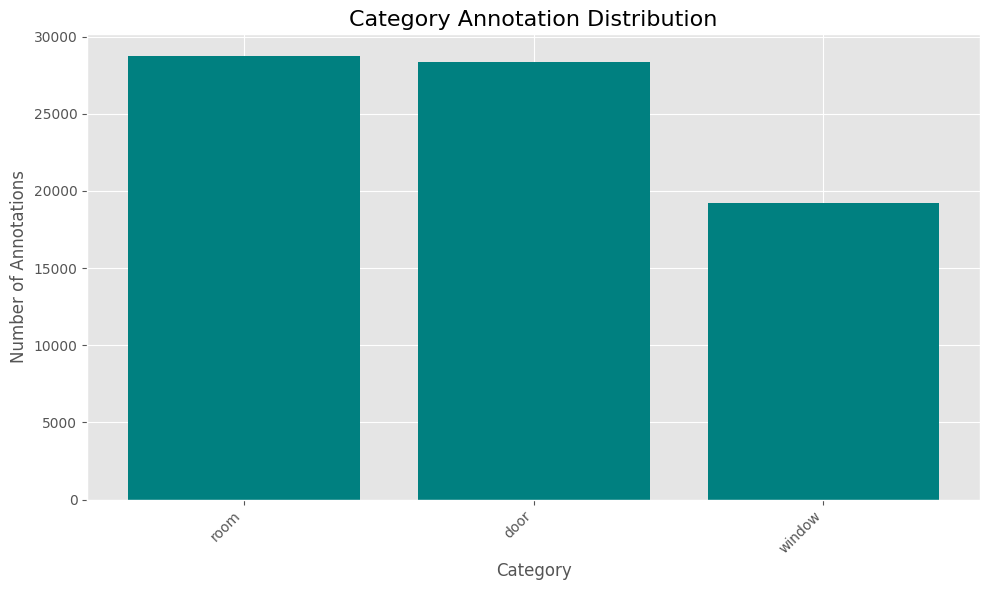

In [ ]:
# ----------------- Module 1: Data Overview & Statistics -----------------

def analyze_dataset_overview(coco_data):
    """
    Analyzes the dataset for a high-level overview and category distribution.
    
    Args:
        coco_data (dict): The loaded COCO format annotations.
    """
    print("--- Dataset Overview & Statistics ---")
    
    total_images = len(coco_data['images'])
    total_annotations = len(coco_data['annotations'])
    
    print(f"Total images in dataset: {total_images}")
    print(f"Total annotations in dataset: {total_annotations}\n")
    
    # Get category names and map them to their IDs
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    # Count annotations per category
    category_counts = defaultdict(int)
    for ann in coco_data['annotations']:
        category_counts[ann['category_id']] += 1
        
    print("--- Category Distribution ---")
    if not category_counts:
        print("Warning: No annotations found in the dataset.")
        return

    # Print the distribution
    for cat_id, count in sorted(category_counts.items()):
        category_name = categories.get(cat_id, 'Unknown')
        print(f"Category '{category_name}' (ID: {cat_id}): {count} annotations")

    # Visualize the category distribution
    plt.style.use('ggplot')
    category_names = [categories.get(cat_id, 'Unknown') for cat_id in category_counts.keys()]
    counts = [count for count in category_counts.values()]
    
    plt.figure(figsize=(10, 6))
    plt.bar(category_names, counts, color='teal')
    plt.title('Category Annotation Distribution', fontsize=16)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Number of Annotations', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#
analyze_dataset_overview(coco_data)


--- Image Size Distribution Analysis ---


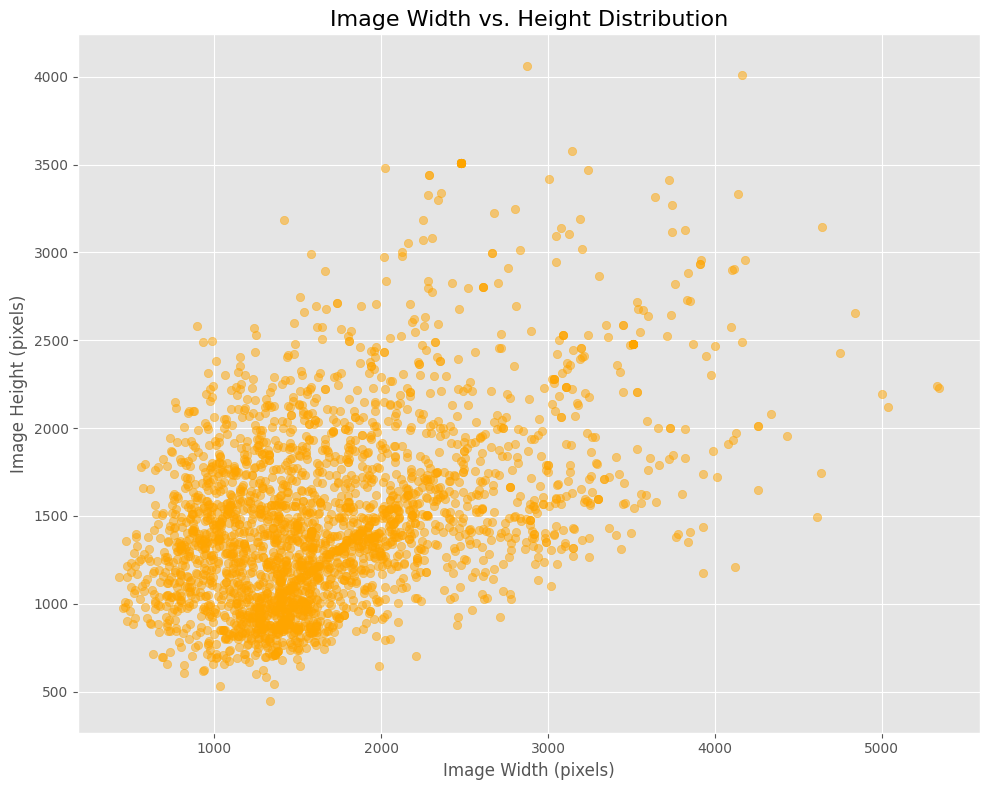

Image size scatter plot saved to: ..\reports\figures\eda\image_size_scatter.png


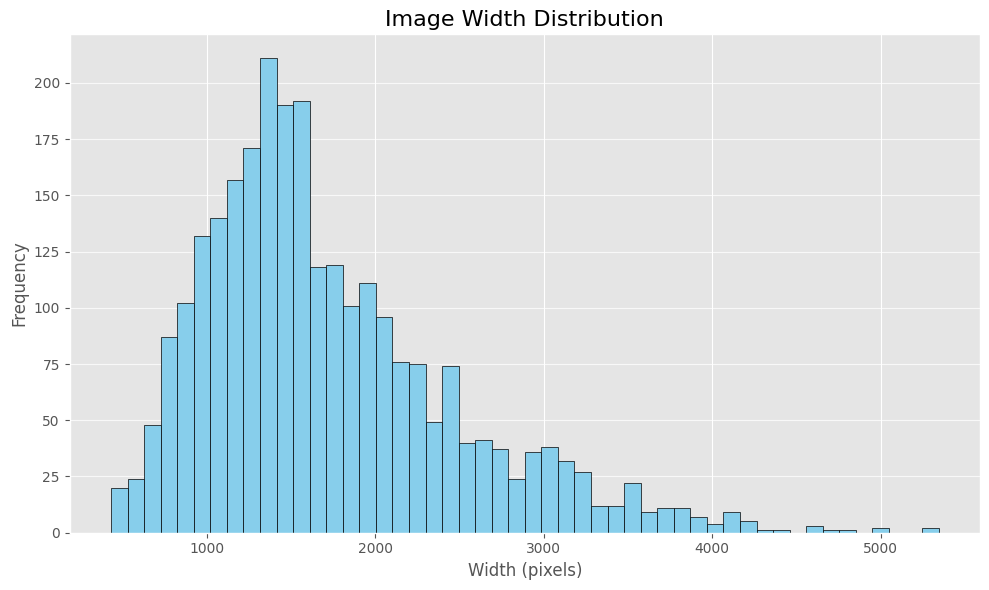

Image width histogram saved to: ..\reports\figures\eda\image_width_histogram.png


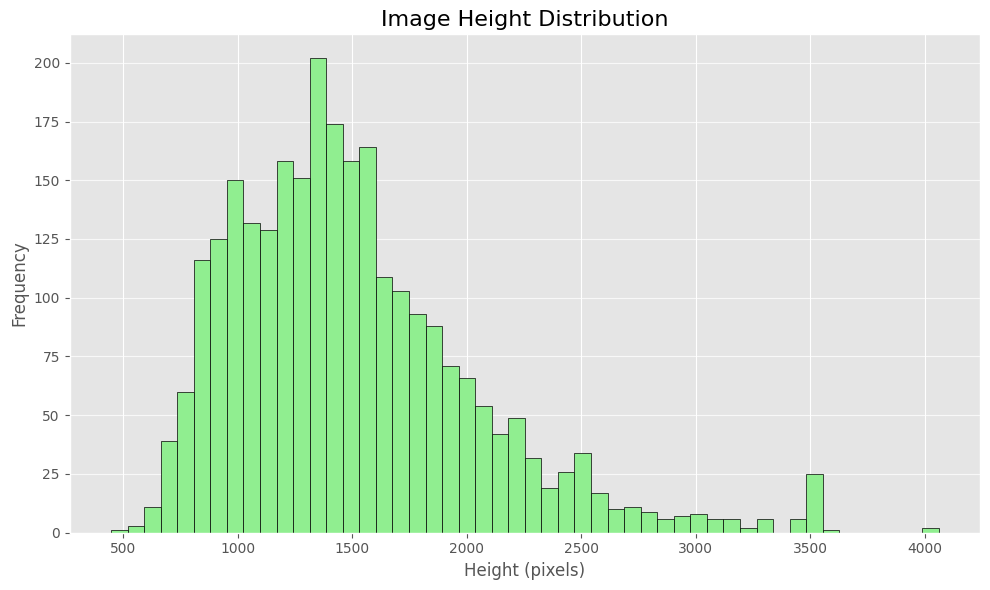

Image height histogram saved to: ..\reports\figures\eda\image_height_histogram.png


In [4]:
# ----------------- Module 2: Image Size Distribution Analysis -----------------

def analyze_image_sizes(coco_data, output_dir: Path):
    """
    Analyzes and visualizes the distribution of image sizes in the dataset.
    
    Args:
        coco_data (dict): The loaded COCO format annotations.
        output_dir (Path): The directory to save visualization plots.
    """
    print("\n--- Image Size Distribution Analysis ---")
    
    image_widths = [img['width'] for img in coco_data['images']]
    image_heights = [img['height'] for img in coco_data['images']]
    
    if not image_widths:
        print("Warning: No image information found in the dataset.")
        return

    # 1. Visualize Width vs. Height with a scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(image_widths, image_heights, alpha=0.5, color='orange')
    plt.title('Image Width vs. Height Distribution', fontsize=16)
    plt.xlabel('Image Width (pixels)', fontsize=12)
    plt.ylabel('Image Height (pixels)', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    scatter_path = output_dir / 'image_size_scatter.png'
    plt.savefig(scatter_path)
    plt.show()
    print(f"Image size scatter plot saved to: {scatter_path}")

    # 2. Visualize Width Distribution with a histogram
    plt.figure(figsize=(10, 6))
    plt.hist(image_widths, bins=50, color='skyblue', edgecolor='black')
    plt.title('Image Width Distribution', fontsize=16)
    plt.xlabel('Width (pixels)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    width_hist_path = output_dir / 'image_width_histogram.png'
    plt.savefig(width_hist_path)
    plt.show()
    print(f"Image width histogram saved to: {width_hist_path}")

    # 3. Visualize Height Distribution with a histogram
    plt.figure(figsize=(10, 6))
    plt.hist(image_heights, bins=50, color='lightgreen', edgecolor='black')
    plt.title('Image Height Distribution', fontsize=16)
    plt.xlabel('Height (pixels)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    height_hist_path = output_dir / 'image_height_histogram.png'
    plt.savefig(height_hist_path)
    plt.show()
    print(f"Image height histogram saved to: {height_hist_path}")

# 示例调用 (Example invocation)
if __name__ == "__main__":
    # Ensure your COCO_FILE and VISUALIZATION_OUTPUT_DIR are defined
    analyze_image_sizes(coco_data, VISUALIZATION_OUTPUT_DIR)


--- Bounding Box Size & Aspect Ratio Analysis ---

Overall Bounding Box Statistics:
  - Total Bounding Boxes: 76289
  - Average Aspect Ratio (Width/Height): 1.3347

Per-Category Bounding Box Statistics:
  - Category 'door' (ID: 1):
    - Count: 28339
    - Average Width: 108.20
    - Average Height: 109.44
    - Average Aspect Ratio (Width/Height): 1.0129
  - Category 'window' (ID: 2):
    - Count: 19236
    - Average Width: 117.90
    - Average Height: 94.58
    - Average Aspect Ratio (Width/Height): 2.1598
  - Category 'room' (ID: 3):
    - Count: 28714
    - Average Width: 281.86
    - Average Height: 277.63
    - Average Aspect Ratio (Width/Height): 1.0995


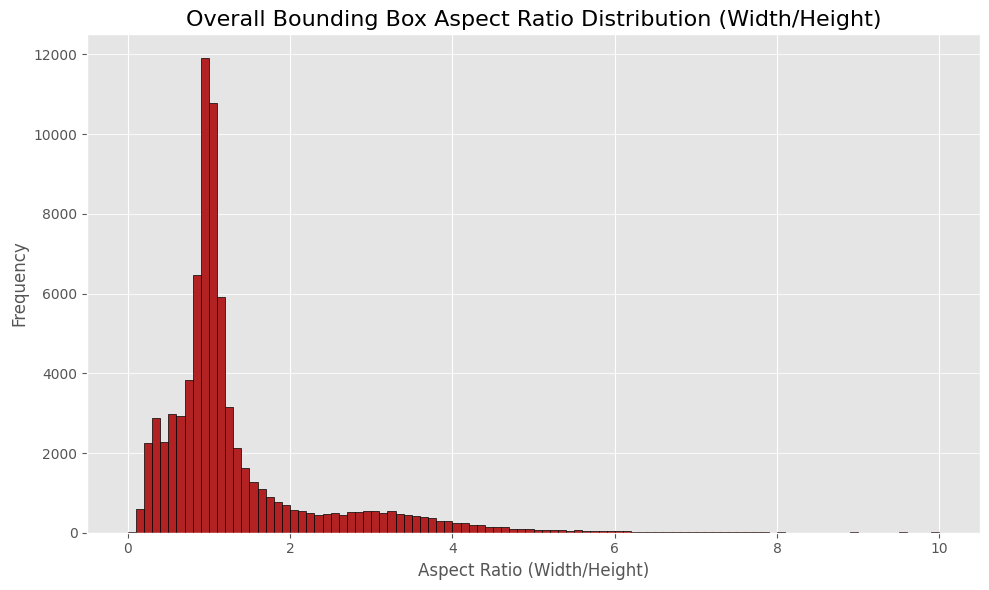

Overall bounding box aspect ratio histogram saved to: ..\reports\figures\eda\bbox_aspect_ratio_histogram.png


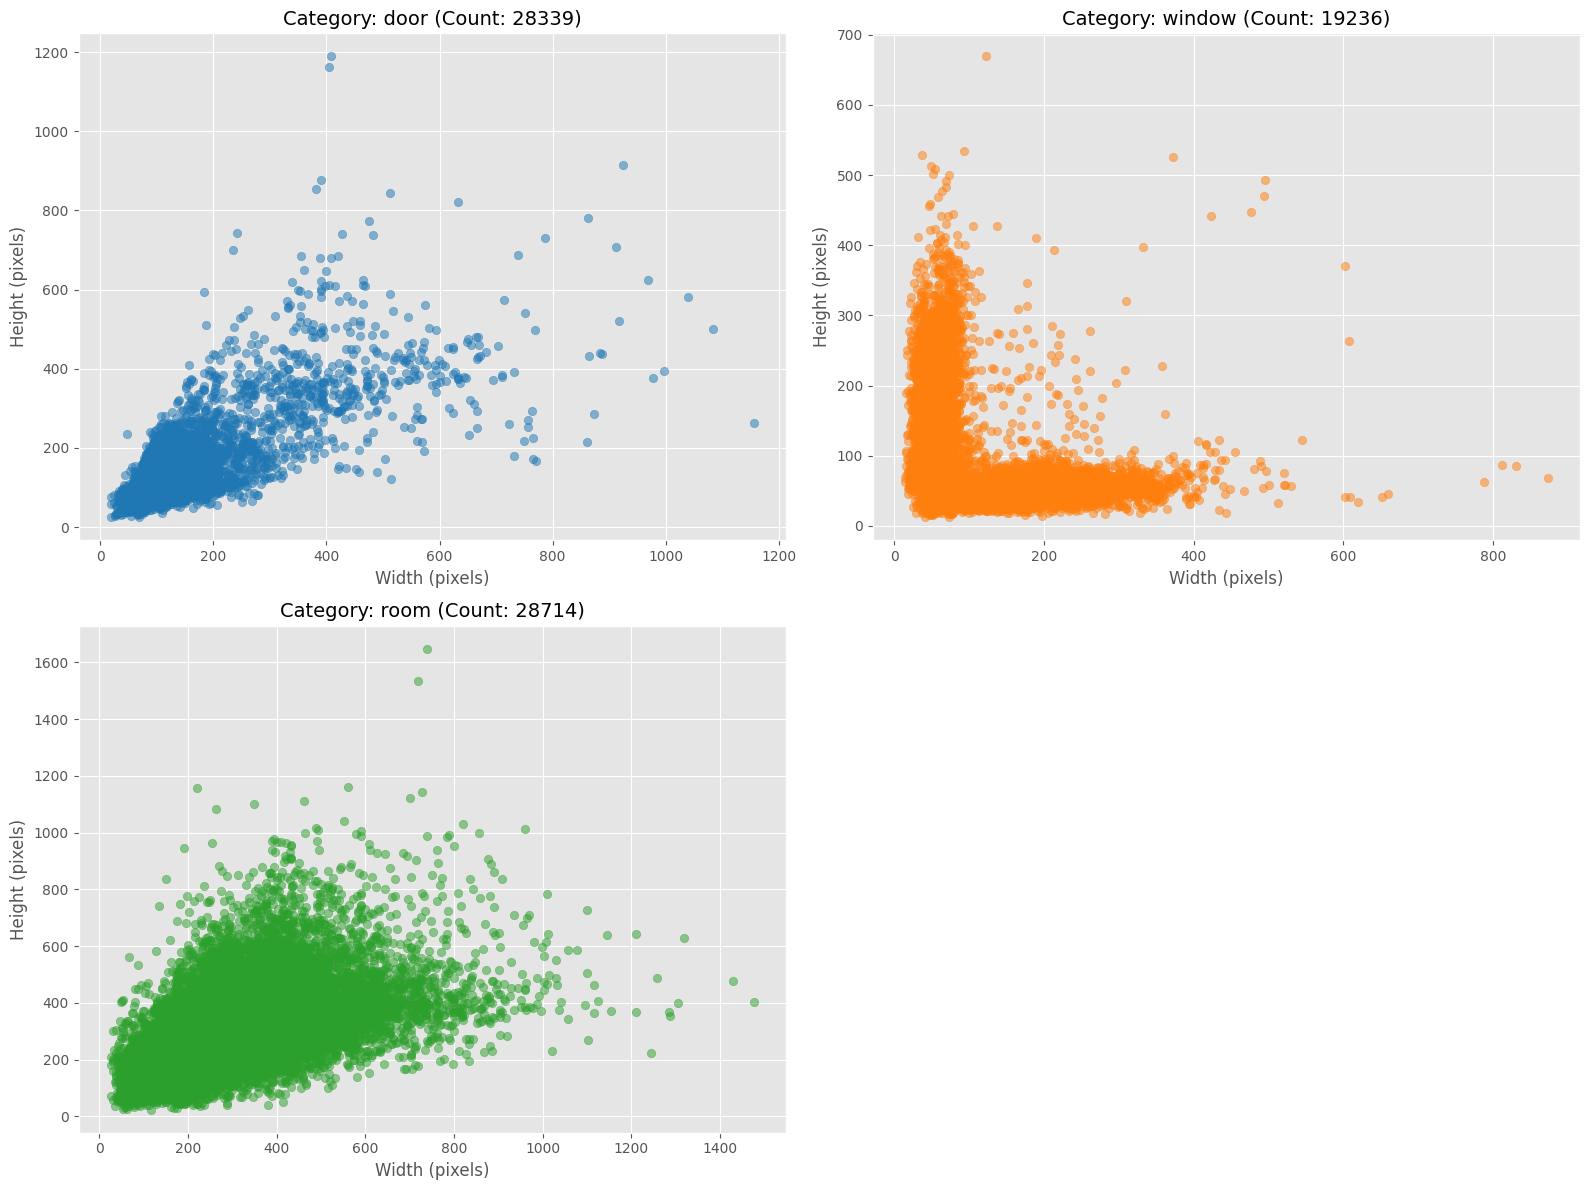

Per-category bounding box size scatter plots saved to: ..\reports\figures\eda\per_category_bbox_size_scatter.png


In [6]:
# ----------------- Module 3: Bounding Box Size & Aspect Ratio Analysis (Enhanced) -----------------

def analyze_bounding_boxes(coco_data, output_dir: Path):
    """
    Analyzes and visualizes the distribution of bounding box sizes and aspect ratios.
    
    Args:
        coco_data (dict): The loaded COCO format annotations.
        output_dir (Path): The directory to save visualization plots.
    """
    print("\n--- Bounding Box Size & Aspect Ratio Analysis ---")
    
    bbox_widths = []
    bbox_heights = []
    bbox_areas = []
    bbox_aspect_ratios = []

    # Data structures for per-category analysis
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    per_category_bboxes = {cat_id: {'widths': [], 'heights': []} for cat_id in categories.keys()}
    
    if not coco_data['annotations']:
        print("Warning: No annotations found in the dataset.")
        return

    for ann in coco_data['annotations']:
        x, y, w, h = ann['bbox']
        cat_id = ann['category_id']
        
        # Avoid zero-sized boxes
        if w > 0 and h > 0:
            bbox_widths.append(w)
            bbox_heights.append(h)
            bbox_areas.append(w * h)
            bbox_aspect_ratios.append(w / h)
            
            # Store per-category bbox dimensions
            per_category_bboxes[cat_id]['widths'].append(w)
            per_category_bboxes[cat_id]['heights'].append(h)
    
    # 1. Overall Bounding Box Statistics
    print("\nOverall Bounding Box Statistics:")
    print(f"  - Total Bounding Boxes: {len(bbox_widths)}")
    print(f"  - Average Aspect Ratio (Width/Height): {np.mean(bbox_aspect_ratios):.4f}")
    
    # 2. Per-Category Bounding Box Statistics
    print("\nPer-Category Bounding Box Statistics:")
    for cat_id, name in categories.items():
        widths = per_category_bboxes[cat_id]['widths']
        heights = per_category_bboxes[cat_id]['heights']
        if widths:
            aspect_ratios = [w / h for w, h in zip(widths, heights)]
            avg_aspect_ratio = np.mean(aspect_ratios)
            print(f"  - Category '{name}' (ID: {cat_id}):")
            print(f"    - Count: {len(widths)}")
            print(f"    - Average Width: {np.mean(widths):.2f}")
            print(f"    - Average Height: {np.mean(heights):.2f}")
            print(f"    - Average Aspect Ratio (Width/Height): {avg_aspect_ratio:.4f}")
    
    # 3. Overall Bounding Box Aspect Ratio Distribution
    plt.figure(figsize=(10, 6))
    plt.hist(bbox_aspect_ratios, bins=100, color='firebrick', edgecolor='black', range=(0, 10))
    plt.title('Overall Bounding Box Aspect Ratio Distribution (Width/Height)', fontsize=16)
    plt.xlabel('Aspect Ratio (Width/Height)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    aspect_ratio_hist_path = output_dir / 'bbox_aspect_ratio_histogram.png'
    plt.savefig(aspect_ratio_hist_path)
    plt.show()
    print(f"Overall bounding box aspect ratio histogram saved to: {aspect_ratio_hist_path}")
    
    # 4. Per-Category Width vs. Height Scatter Plots
    plt.style.use('ggplot')
    num_categories = len(categories)
    num_cols = 2
    num_rows = (num_categories + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows), squeeze=False)
    
    for idx, (cat_id, name) in enumerate(categories.items()):
        row = idx // num_cols
        col = idx % num_cols
        ax = axes[row, col]
        
        widths = per_category_bboxes[cat_id]['widths']
        heights = per_category_bboxes[cat_id]['heights']
        
        if widths:
            ax.scatter(widths, heights, alpha=0.5, color=plt.cm.tab10(idx % 10))
            ax.set_title(f'Category: {name} (Count: {len(widths)})', fontsize=14)
            ax.set_xlabel('Width (pixels)', fontsize=12)
            ax.set_ylabel('Height (pixels)', fontsize=12)
            ax.grid(True)
        else:
            ax.set_title(f'Category: {name} (No annotations)', fontsize=14)
            ax.axis('off')
            
    # Hide unused subplots
    for i in range(num_categories, num_rows * num_cols):
        axes.flatten()[i].axis('off')
    
    plt.tight_layout()
    scatter_path = output_dir / 'per_category_bbox_size_scatter.png'
    plt.savefig(scatter_path)
    plt.show()
    print(f"Per-category bounding box size scatter plots saved to: {scatter_path}")


# 示例调用 (Example invocation)
if __name__ == "__main__":
    # Ensure your coco_data and VISUALIZATION_OUTPUT_DIR are defined
    analyze_bounding_boxes(coco_data, VISUALIZATION_OUTPUT_DIR)


--- Bounding Box Location Analysis ---


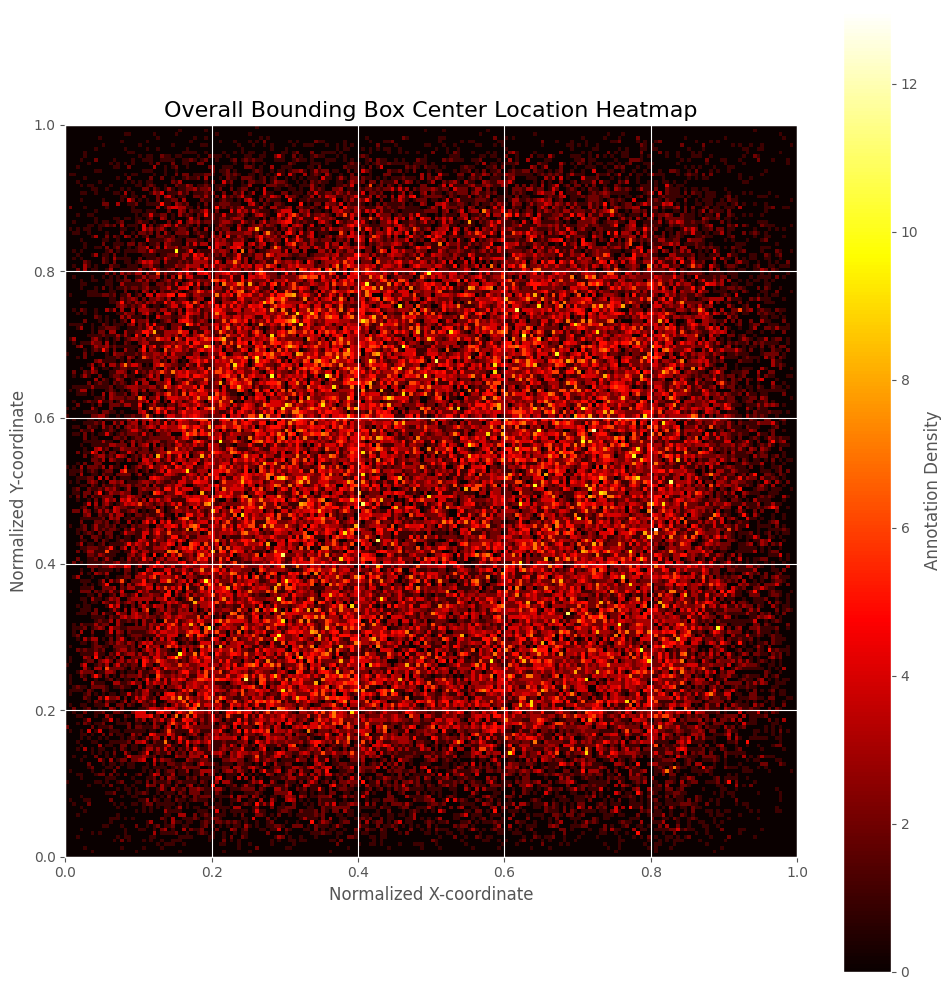

Overall bounding box location heatmap saved to: ..\reports\figures\eda\overall_bbox_location_heatmap.png


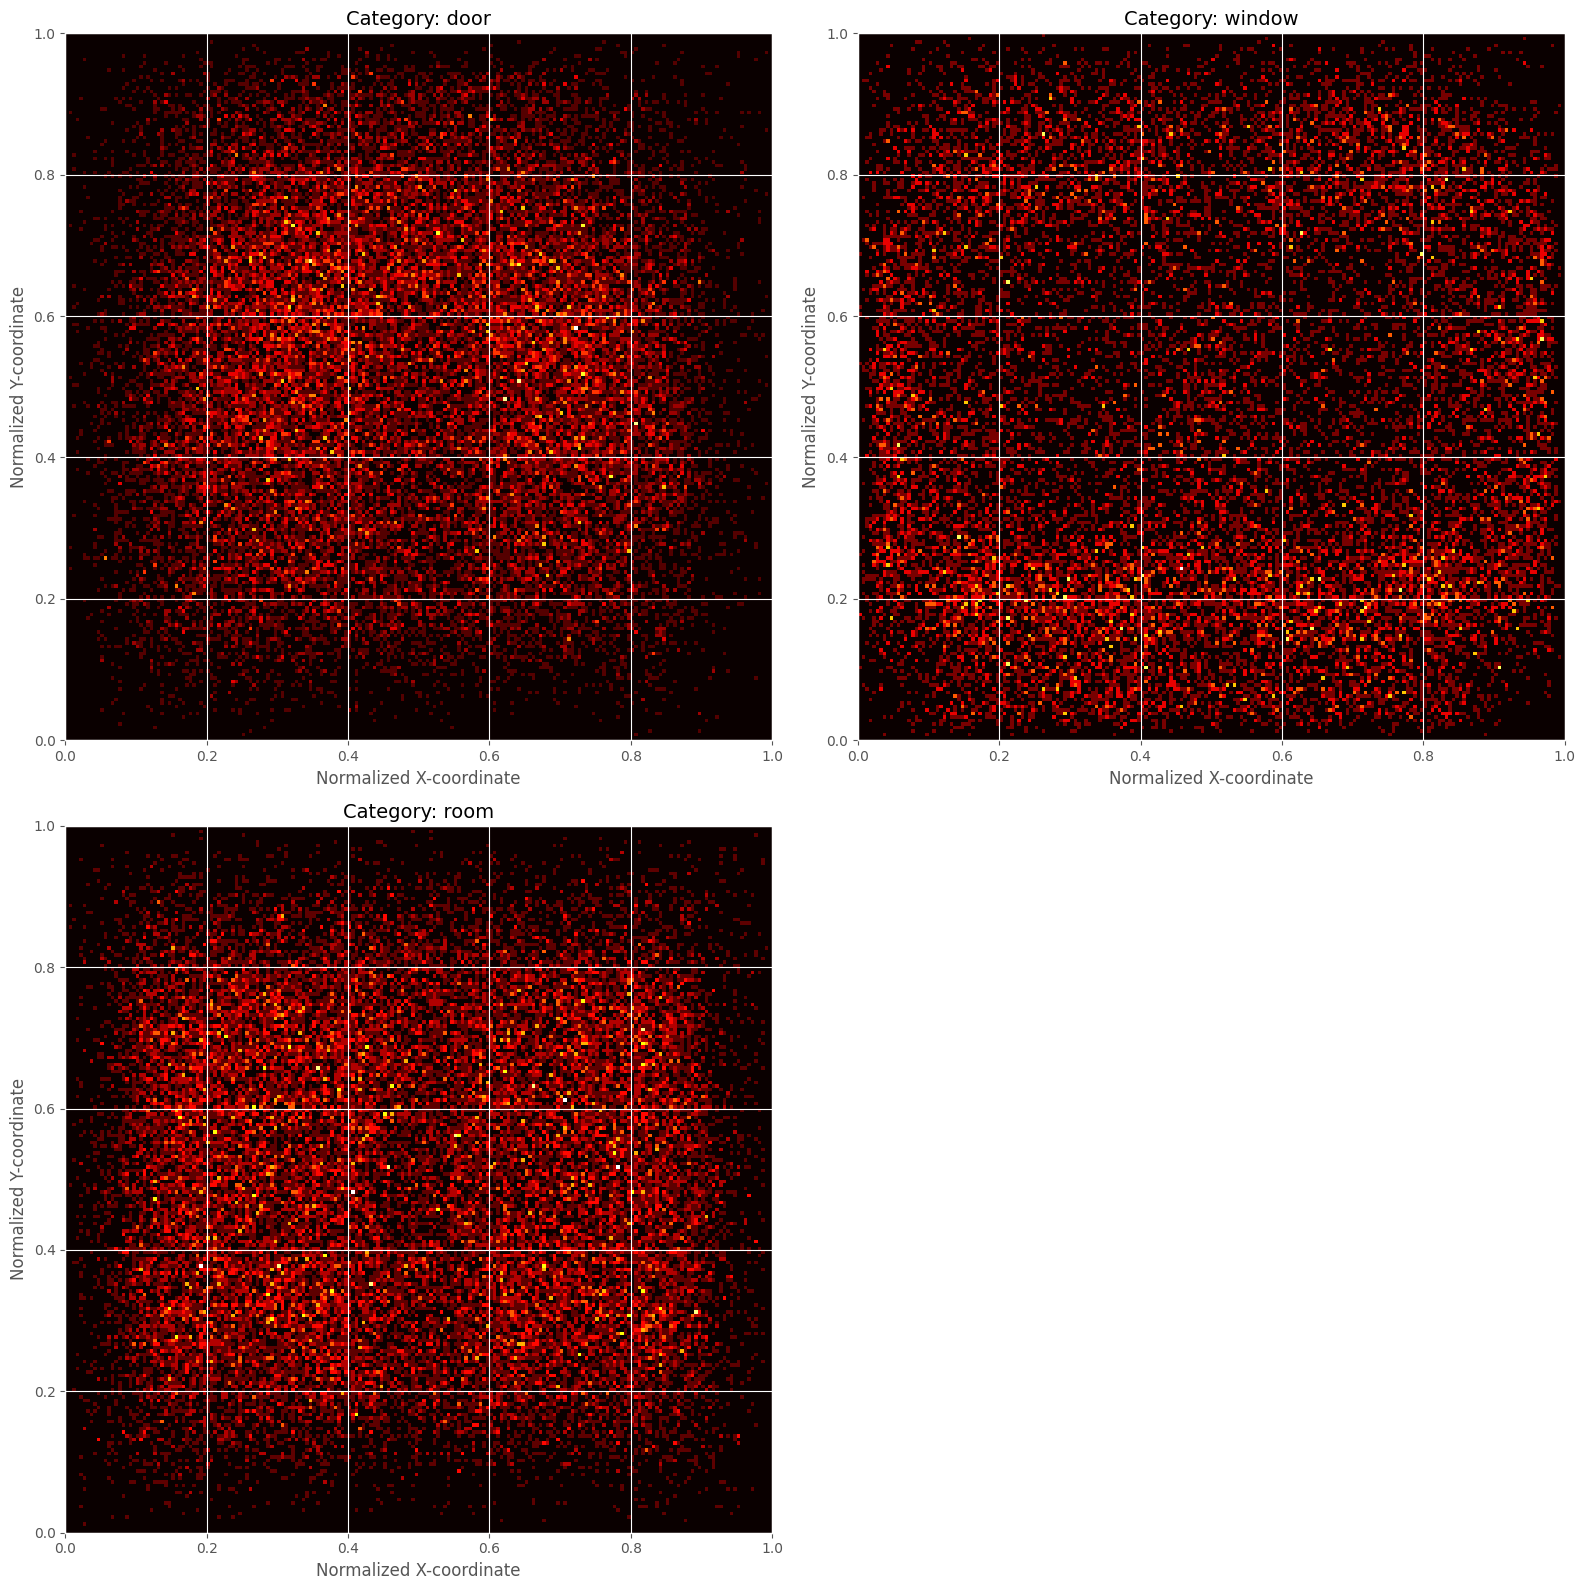

Per-category bounding box location heatmaps saved to: ..\reports\figures\eda\per_category_bbox_location_heatmap.png


In [11]:
# ----------------- Module 4: Bounding Box Location Analysis (Enhanced) -----------------

def analyze_bbox_locations(coco_data, output_dir: Path):
    """
    Analyzes and visualizes the distribution of bounding box center locations, both overall and by category.
    
    Args:
        coco_data (dict): The loaded COCO format annotations.
        output_dir (Path): The directory to save visualization plots.
    """
    print("\n--- Bounding Box Location Analysis ---")
    
    # Store normalized center coordinates for overall heatmap
    overall_center_x = []
    overall_center_y = []
    
    # Store normalized center coordinates for per-category heatmaps
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    per_category_centers = {cat_id: {'x': [], 'y': []} for cat_id in categories.keys()}
    
    image_info_map = {img['id']: (img['width'], img['height']) for img in coco_data['images']}
    
    if not coco_data['annotations']:
        print("Warning: No annotations found in the dataset.")
        return

    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        cat_id = ann['category_id']
        img_width, img_height = image_info_map.get(image_id, (0, 0))
        
        if img_width == 0 or img_height == 0:
            continue
            
        x, y, w, h = ann['bbox']
        
        # Calculate normalized center coordinates
        cx = (x + w / 2) / img_width
        cy = (y + h / 2) / img_height
        
        overall_center_x.append(cx)
        overall_center_y.append(cy)
        
        if cat_id in per_category_centers:
            per_category_centers[cat_id]['x'].append(cx)
            per_category_centers[cat_id]['y'].append(cy)

    # 1. Overall Bounding Box Center Location Heatmap
    plt.figure(figsize=(10, 10))
    hist, _, _ = np.histogram2d(overall_center_x, overall_center_y, bins=200, range=[[0, 1], [0, 1]])
    plt.imshow(hist.T, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
    plt.colorbar(label='Annotation Density')
    plt.title('Overall Bounding Box Center Location Heatmap', fontsize=16)
    plt.xlabel('Normalized X-coordinate', fontsize=12)
    plt.ylabel('Normalized Y-coordinate', fontsize=12)
    plt.tight_layout()
    heatmap_path = output_dir / 'overall_bbox_location_heatmap.png'
    plt.savefig(heatmap_path)
    plt.show()
    print(f"Overall bounding box location heatmap saved to: {heatmap_path}")

    # 2. Per-Category Bounding Box Center Location Heatmaps
    num_categories = len(categories)
    num_cols = 2
    num_rows = (num_categories + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 8 * num_rows), squeeze=False)
    
    for idx, (cat_id, name) in enumerate(categories.items()):
        row = idx // num_cols
        col = idx % num_cols
        ax = axes[row, col]
        
        if cat_id in per_category_centers:
            centers_x = per_category_centers[cat_id]['x']
            centers_y = per_category_centers[cat_id]['y']
            
            if centers_x:
                hist, _, _ = np.histogram2d(centers_x, centers_y, bins=200, range=[[0, 1], [0, 1]])
                ax.imshow(hist.T, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
                ax.set_title(f'Category: {name}', fontsize=14)
                ax.set_xlabel('Normalized X-coordinate', fontsize=12)
                ax.set_ylabel('Normalized Y-coordinate', fontsize=12)
                # Note: No colorbar per subplot to avoid clutter
            else:
                ax.set_title(f'Category: {name} (No annotations)', fontsize=14)
                ax.axis('off')
        
    # Hide unused subplots
    for i in range(num_categories, num_rows * num_cols):
        axes.flatten()[i].axis('off')
    
    plt.tight_layout()
    per_category_heatmap_path = output_dir / 'per_category_bbox_location_heatmap.png'
    plt.savefig(per_category_heatmap_path)
    plt.show()
    print(f"Per-category bounding box location heatmaps saved to: {per_category_heatmap_path}")


# 示例调用 (Example invocation)
if __name__ == "__main__":
    # Ensure your coco_data and VISUALIZATION_OUTPUT_DIR are defined
    analyze_bbox_locations(coco_data, VISUALIZATION_OUTPUT_DIR)

In [ ]:
# ----------------- Module 5: Random Image Annotation Visualization-----------------

def draw_bboxes_with_colors(ax, image, annotations, categories, cat_colors):
    """
    Draws bounding boxes on an image with category-specific colors.
    """
    for ann in annotations:
        x, y, w, h = ann['bbox']
        cat_id = ann['category_id']
        color = cat_colors.get(cat_id, (1, 0, 0, 1))
        
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Add label with category name
        label = categories.get(cat_id, 'Unknown')
        ax.text(x, y - 5, label, color='white', fontsize=8, bbox=dict(facecolor=color, alpha=0.5))

def visualize_random_image_annotations(coco_data, random_image_id):
    """
    Visualizes annotations of a specified image with unique colors per category.
    
    Args:
        coco_data (dict): The complete COCO data dictionary.
        random_image_id (int): The ID of the image to be visualized.
    """
    print(f"\n--- Visualizing a Random Image with Annotations ---")
    
    # Get the image file path
    image_file = image_id_to_filename.get(random_image_id)
    image_path = IMAGES_DIR / image_file

    if not image_path.exists():
        print(f"Error: Image file not found at {image_path}")
        return

    # Load the image
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"Error: Could not read image from {image_path}")
        return
        
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get annotations and category info
    annotations = annotations_by_image.get(random_image_id, [])
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}

    # Create a color map for categories
    colors = plt.cm.get_cmap('tab10', len(categories))
    cat_colors = {cat_id: colors(i) for i, cat_id in enumerate(categories.keys())}
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img_rgb)
    ax.set_title(f"Random Image ID: {random_image_id}, File: {image_file}", fontsize=14)
    ax.axis('off')

    # Draw the bounding boxes
    draw_bboxes_with_colors(ax, img_rgb, annotations, categories, cat_colors)
    
    plt.show()
    print(f"Successfully visualized image ID {random_image_id}.")

# --- Main execution of module 5 ---
if __name__ == "__main__":  
    # Check if there are any images in the dataset
    if not coco_data['images']:
        print("Error: No images found in the COCO data.")
    else:
        #Randomly select a single image ID
        image_ids = [img['id'] for img in coco_data['images']]
        random_image_id = np.random.choice(image_ids)    
        visualize_random_image_annotations(coco_data, random_image_id)